# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 36kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

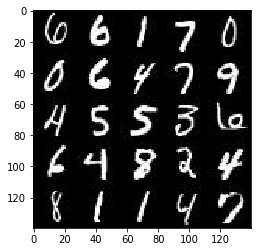

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

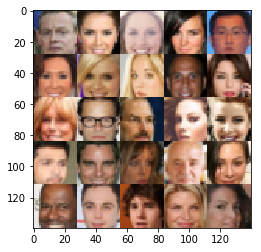

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name= 'input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name= 'learning_rate')
    

    return (input_real, input_z, learning_rate)



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start\n    handler_func(fd_obj, events)', 'File "/opt/conda/lib/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #input layer is 28*28*n_channels
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #14*14*64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #7*7*128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(bn3 * alpha, bn3)
        #4*4*256

        #flatten layer
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    
    
    
    

    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        #First fully connected layer
        x1 = tf.layers.dense(z, 7 * 7  * 512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #14*14*512
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x2, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #28*28*128
        
        #Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list = g_vars)
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    images_count, image_width, image_height, image_channels = data_shape
    
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    # TODO: Train Model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                
                #Change the range from (-0.5, 0.5) to (-1, 1)
                batch_images *= 2
                
                #Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #Run Optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate : learning_rate })
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate : learning_rate })
                
                
                if steps % 10 == 0:
                    #Get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                           "Generator Loss: {:.4f}".format(train_loss_g))
                
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.9466... Generator Loss: 1.8001
Epoch 1/2... Discriminator Loss: 1.1992... Generator Loss: 4.0203
Epoch 1/2... Discriminator Loss: 0.4732... Generator Loss: 2.6683
Epoch 1/2... Discriminator Loss: 0.7520... Generator Loss: 1.6684
Epoch 1/2... Discriminator Loss: 1.4573... Generator Loss: 0.5609
Epoch 1/2... Discriminator Loss: 1.8595... Generator Loss: 0.2485
Epoch 1/2... Discriminator Loss: 0.8268... Generator Loss: 1.4222
Epoch 1/2... Discriminator Loss: 1.3071... Generator Loss: 1.3168
Epoch 1/2... Discriminator Loss: 1.0508... Generator Loss: 1.4016
Epoch 1/2... Discriminator Loss: 1.1737... Generator Loss: 0.6060


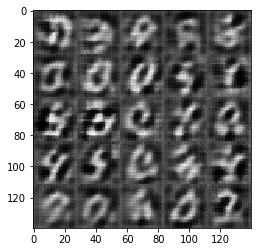

Epoch 1/2... Discriminator Loss: 1.1311... Generator Loss: 1.1682
Epoch 1/2... Discriminator Loss: 1.1426... Generator Loss: 0.8011
Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 0.5013
Epoch 1/2... Discriminator Loss: 1.2811... Generator Loss: 0.5883
Epoch 1/2... Discriminator Loss: 1.2843... Generator Loss: 1.1632
Epoch 1/2... Discriminator Loss: 1.7482... Generator Loss: 0.2511
Epoch 1/2... Discriminator Loss: 1.0991... Generator Loss: 1.2621
Epoch 1/2... Discriminator Loss: 1.1519... Generator Loss: 0.6651
Epoch 1/2... Discriminator Loss: 1.4668... Generator Loss: 0.3736
Epoch 1/2... Discriminator Loss: 1.1908... Generator Loss: 1.3258


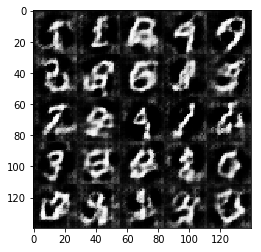

Epoch 1/2... Discriminator Loss: 1.2196... Generator Loss: 1.3719
Epoch 1/2... Discriminator Loss: 1.5888... Generator Loss: 0.3421
Epoch 1/2... Discriminator Loss: 1.1764... Generator Loss: 0.7782
Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 1.8961
Epoch 1/2... Discriminator Loss: 1.2763... Generator Loss: 0.4491
Epoch 1/2... Discriminator Loss: 1.3377... Generator Loss: 0.4915
Epoch 1/2... Discriminator Loss: 1.0800... Generator Loss: 1.0132
Epoch 1/2... Discriminator Loss: 1.1263... Generator Loss: 0.9415
Epoch 1/2... Discriminator Loss: 1.2357... Generator Loss: 0.8346
Epoch 1/2... Discriminator Loss: 1.1758... Generator Loss: 0.5816


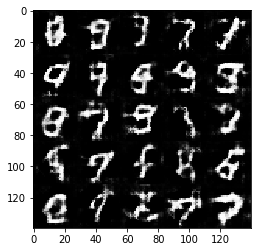

Epoch 1/2... Discriminator Loss: 1.1672... Generator Loss: 1.2639
Epoch 1/2... Discriminator Loss: 1.2399... Generator Loss: 0.5447
Epoch 1/2... Discriminator Loss: 1.3304... Generator Loss: 0.4448
Epoch 1/2... Discriminator Loss: 1.3259... Generator Loss: 1.6072
Epoch 1/2... Discriminator Loss: 1.2042... Generator Loss: 1.2643
Epoch 1/2... Discriminator Loss: 1.1852... Generator Loss: 0.5793
Epoch 1/2... Discriminator Loss: 1.6579... Generator Loss: 2.0818
Epoch 1/2... Discriminator Loss: 1.1036... Generator Loss: 0.7763
Epoch 1/2... Discriminator Loss: 1.2364... Generator Loss: 1.6671
Epoch 1/2... Discriminator Loss: 1.1091... Generator Loss: 1.4634


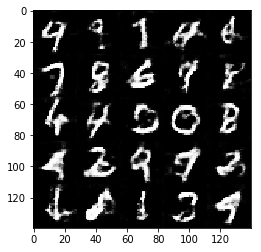

Epoch 1/2... Discriminator Loss: 1.2973... Generator Loss: 1.7136
Epoch 1/2... Discriminator Loss: 1.1809... Generator Loss: 0.9289
Epoch 1/2... Discriminator Loss: 1.0890... Generator Loss: 0.6739
Epoch 1/2... Discriminator Loss: 1.1114... Generator Loss: 1.0885
Epoch 1/2... Discriminator Loss: 0.9618... Generator Loss: 1.1140
Epoch 1/2... Discriminator Loss: 2.3454... Generator Loss: 0.1350
Epoch 2/2... Discriminator Loss: 1.0284... Generator Loss: 0.8575
Epoch 2/2... Discriminator Loss: 1.0726... Generator Loss: 1.6400
Epoch 2/2... Discriminator Loss: 1.1856... Generator Loss: 0.5648
Epoch 2/2... Discriminator Loss: 1.4883... Generator Loss: 0.3378


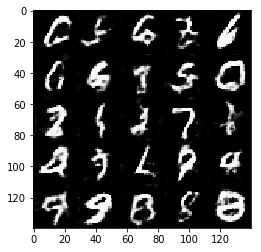

Epoch 2/2... Discriminator Loss: 1.1521... Generator Loss: 0.6929
Epoch 2/2... Discriminator Loss: 1.0854... Generator Loss: 1.2690
Epoch 2/2... Discriminator Loss: 1.0936... Generator Loss: 0.6381
Epoch 2/2... Discriminator Loss: 1.0078... Generator Loss: 0.8157
Epoch 2/2... Discriminator Loss: 1.8190... Generator Loss: 1.7184
Epoch 2/2... Discriminator Loss: 0.9720... Generator Loss: 0.9979
Epoch 2/2... Discriminator Loss: 1.0901... Generator Loss: 0.6473
Epoch 2/2... Discriminator Loss: 1.0371... Generator Loss: 1.0113
Epoch 2/2... Discriminator Loss: 0.9868... Generator Loss: 0.7421
Epoch 2/2... Discriminator Loss: 1.1794... Generator Loss: 0.5880


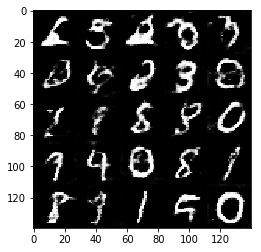

Epoch 2/2... Discriminator Loss: 1.1565... Generator Loss: 0.7040
Epoch 2/2... Discriminator Loss: 1.2499... Generator Loss: 0.6474
Epoch 2/2... Discriminator Loss: 1.0793... Generator Loss: 0.7089
Epoch 2/2... Discriminator Loss: 1.4343... Generator Loss: 0.3807
Epoch 2/2... Discriminator Loss: 1.1721... Generator Loss: 1.1147
Epoch 2/2... Discriminator Loss: 1.0571... Generator Loss: 0.6620
Epoch 2/2... Discriminator Loss: 1.2647... Generator Loss: 1.6996
Epoch 2/2... Discriminator Loss: 0.9749... Generator Loss: 0.8362
Epoch 2/2... Discriminator Loss: 1.2026... Generator Loss: 0.5729
Epoch 2/2... Discriminator Loss: 1.0818... Generator Loss: 0.8561


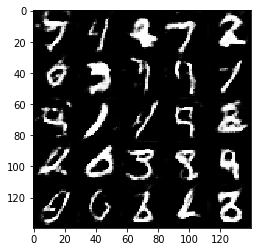

Epoch 2/2... Discriminator Loss: 1.2907... Generator Loss: 0.5538
Epoch 2/2... Discriminator Loss: 1.1054... Generator Loss: 1.3494
Epoch 2/2... Discriminator Loss: 1.1728... Generator Loss: 0.5061
Epoch 2/2... Discriminator Loss: 1.4629... Generator Loss: 1.9789
Epoch 2/2... Discriminator Loss: 1.1295... Generator Loss: 0.6367
Epoch 2/2... Discriminator Loss: 1.0087... Generator Loss: 0.9076
Epoch 2/2... Discriminator Loss: 1.3537... Generator Loss: 1.2993
Epoch 2/2... Discriminator Loss: 1.3033... Generator Loss: 0.4427
Epoch 2/2... Discriminator Loss: 1.0404... Generator Loss: 0.8078
Epoch 2/2... Discriminator Loss: 0.9103... Generator Loss: 1.1003


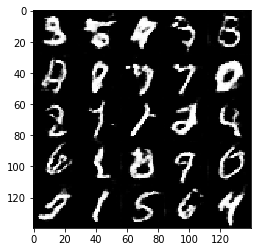

Epoch 2/2... Discriminator Loss: 1.0021... Generator Loss: 0.9445
Epoch 2/2... Discriminator Loss: 1.0431... Generator Loss: 1.4331
Epoch 2/2... Discriminator Loss: 0.9509... Generator Loss: 0.7165
Epoch 2/2... Discriminator Loss: 1.2595... Generator Loss: 2.1725
Epoch 2/2... Discriminator Loss: 1.1099... Generator Loss: 0.7195
Epoch 2/2... Discriminator Loss: 1.0058... Generator Loss: 1.0853
Epoch 2/2... Discriminator Loss: 1.3893... Generator Loss: 0.4324
Epoch 2/2... Discriminator Loss: 0.8980... Generator Loss: 0.9219
Epoch 2/2... Discriminator Loss: 0.9036... Generator Loss: 1.3633
Epoch 2/2... Discriminator Loss: 0.9092... Generator Loss: 0.8436


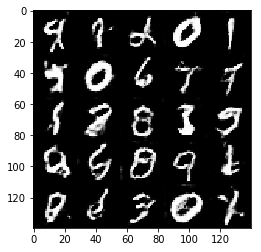

Epoch 2/2... Discriminator Loss: 1.4004... Generator Loss: 0.4123
Epoch 2/2... Discriminator Loss: 1.0835... Generator Loss: 0.6509
Epoch 2/2... Discriminator Loss: 0.7687... Generator Loss: 1.2218


In [23]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1798... Generator Loss: 21.5477
Epoch 1/1... Discriminator Loss: 0.6563... Generator Loss: 6.0199
Epoch 1/1... Discriminator Loss: 1.8908... Generator Loss: 0.5623
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 1.1783
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 3.4871
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.8051... Generator Loss: 3.2365
Epoch 1/1... Discriminator Loss: 1.5926... Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 1.2340


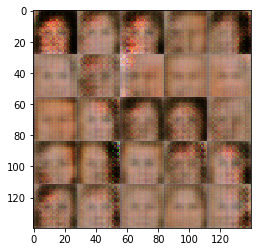

Epoch 1/1... Discriminator Loss: 0.8596... Generator Loss: 3.5638
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 0.6300... Generator Loss: 1.8830
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 2.1414... Generator Loss: 2.4698
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 1.8875
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 2.2873
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 1.3955
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.9324


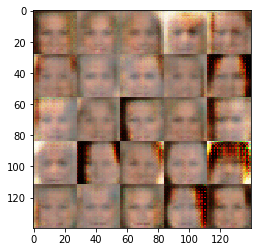

Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.4961
Epoch 1/1... Discriminator Loss: 1.5563... Generator Loss: 1.6338
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 1.0937
Epoch 1/1... Discriminator Loss: 0.8889... Generator Loss: 1.0521
Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 1.1716
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.6996... Generator Loss: 0.2559


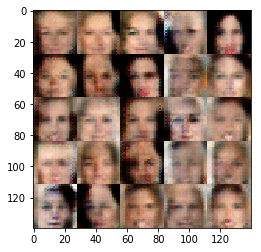

Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 2.1828... Generator Loss: 3.0244
Epoch 1/1... Discriminator Loss: 0.7192... Generator Loss: 1.6205
Epoch 1/1... Discriminator Loss: 0.5974... Generator Loss: 1.7077
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 1.1254


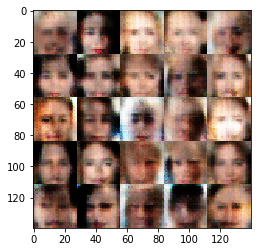

Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 1.0410
Epoch 1/1... Discriminator Loss: 0.8293... Generator Loss: 2.0624
Epoch 1/1... Discriminator Loss: 2.2549... Generator Loss: 2.4359
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 1.3263
Epoch 1/1... Discriminator Loss: 1.6627... Generator Loss: 1.0237
Epoch 1/1... Discriminator Loss: 0.3151... Generator Loss: 1.8159
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 1.1056
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.3423
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 0.9642
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.7806


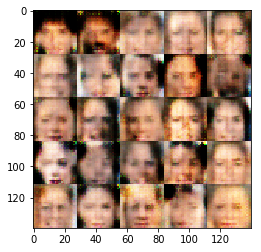

Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 2.6013... Generator Loss: 2.0241
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.8645... Generator Loss: 0.1969
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 1.6700
Epoch 1/1... Discriminator Loss: 0.7136... Generator Loss: 1.1880
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.6697


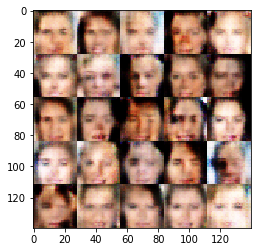

Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 1.2229
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 1.2196
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 1.4447
Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 1.0582
Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 1.0735
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 3.3844... Generator Loss: 3.5866


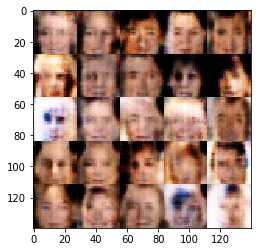

Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.8996
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 0.9534... Generator Loss: 1.5386
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 1.8034
Epoch 1/1... Discriminator Loss: 0.7337... Generator Loss: 1.3828


In [24]:
batch_size = 256
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.